# Kinematics Analysis

In [1]:
from cyto.postprocessing.graph import *
from cyto.utils.label_to_table import *
import dask_image.imread
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import numpy as np
import pyclesperanto_prototype as cle
import pandas as pd

### Load ultrack mapped, area-sized filtered and track_length pre-filtered tracks or signal mapped dataframes from example 5 

In [2]:
tracks_df_filtered_tcell = pd.read_csv("/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/tracks/tcell_tracks/tracks/20231017_roi-0_6480-8639_binT-1_tcell/tcell_tracks_filtered_3.csv")
# tracks_df_filtered_cancer = pd.read_csv("/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/tracks/cancer_tracks/tracks/cancer_tracks_filtered.csv")
tracks_df_filtered_tcell.drop("Unnamed: 0", axis=1, inplace=True)
# tracks_df_filtered_cancer.drop("Unnamed: 0", axis=1, inplace=True)

# Perform Kinematics Calculations

## T Cells

In [3]:
# # displacement
diff = tracks_df_filtered_tcell.groupby("track_id")[["x","y","frame"]].diff()
tracks_df_filtered_tcell["dx from previous point"] = diff["x"].fillna(0)
tracks_df_filtered_tcell["dy from previous point"] = diff["y"].fillna(0)
tracks_df_filtered_tcell["displacement from previous point"] = np.linalg.norm(tracks_df_filtered_tcell[["dx from previous point","dy from previous point"]], axis=1)

tracks_df_filtered_tcell["dx from origin"] = tracks_df_filtered_tcell.groupby(['track_id'])['dx from previous point'].cumsum().fillna(0)
tracks_df_filtered_tcell["dy from origin"] = tracks_df_filtered_tcell.groupby(['track_id'])['dy from previous point'].cumsum().fillna(0)
tracks_df_filtered_tcell["displacement from origin"] = np.linalg.norm(tracks_df_filtered_tcell[["dx from origin","dy from origin"]], axis=1)
tracks_df_filtered_tcell["dx acc"] = diff["x"].apply(lambda x: abs(x)).fillna(0) # abs displacement
tracks_df_filtered_tcell["dy acc"] = diff["y"].apply(lambda x: abs(x)).fillna(0) # abs displacement
tracks_df_filtered_tcell["dx acc"] = tracks_df_filtered_tcell.groupby(['track_id'])['dx acc'].cumsum()
tracks_df_filtered_tcell["dy acc"] = tracks_df_filtered_tcell.groupby(['track_id'])['dy acc'].cumsum()
tracks_df_filtered_tcell["distance travelled"] = tracks_df_filtered_tcell.groupby(['track_id'])['displacement from previous point'].cumsum()


# velocity
tracks_df_filtered_tcell["vel_x"] = (diff["x"]/diff["frame"]).fillna(0)
tracks_df_filtered_tcell["vel_y"] = (diff["y"]/diff["frame"]).fillna(0)
tracks_df_filtered_tcell["speed"] = (np.linalg.norm(diff[["x","y"]], axis=1)/diff['frame']).fillna(0)
tracks_df_filtered_tcell["speed acc"] = tracks_df_filtered_tcell.groupby(['track_id'])['speed'].cumsum().fillna(0)
# TODO: Track tortuosity

tracks_df_filtered_tcell

,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,...,dx from origin,dy from origin,displacement from origin,dx acc,dy acc,distance travelled,vel_x,vel_y,speed,speed acc
0,1372,76.845070,7.971831,4,72,9,11,7.971831,76.845070,4.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,640,80.000000,18.078431,12,75,13,11,18.078431,80.000000,12.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,4162,79.461538,28.589744,25,77,8,6,28.589744,79.461538,25.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1415,336.428571,2.514286,0,330,7,13,2.514286,336.428571,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1556,437.119403,7.402985,3,433,10,10,7.402985,437.119403,3.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14353892,16094374,874.375000,971.458333,969,872,6,6,971.458333,874.375000,969.0,...,-1.334770,-1.797414,2.238818,37.616643,32.239910,54.304127,-1.291667,-2.163462,2.519716,54.171221
14353893,16090382,893.479167,979.645833,976,889,8,9,979.645833,893.479167,976.0,...,-7.937500,20.933114,22.387478,40.981165,54.133543,75.675600,-0.562500,-0.208333,0.599841,59.036365
14353894,16090254,896.979592,966.081633,962,894,9,8,966.081633,896.979592,962.0,...,-18.404854,3.141754,18.671081,44.917273,31.237601,60.776689,-0.104414,0.235406,0.257523,60.063621
14353895,16091620,684.075000,977.050000,974,681,7,7,977.050000,684.075000,974.0,...,0.223913,3.031522,3.039780,25.495470,12.741447,30.352613,0.074390,-0.046951,0.087968,24.630843


## Cancer Cells

In [45]:
# # displacement
diff_cancer = tracks_df_filtered_cancer.groupby("track_id")[["x","y","frame"]].diff()
tracks_df_filtered_cancer["dx from previous point"] = diff_cancer["x"].fillna(0)
tracks_df_filtered_cancer["dy from previous point"] = diff_cancer["y"].fillna(0)
tracks_df_filtered_cancer["displacement from previous point"] = np.linalg.norm(tracks_df_filtered_cancer[["dx from previous point","dy from previous point"]], axis=1)

tracks_df_filtered_cancer["dx from origin"] = tracks_df_filtered_cancer.groupby(['track_id'])['dx from previous point'].cumsum().fillna(0)
tracks_df_filtered_cancer["dy from origin"] = tracks_df_filtered_cancer.groupby(['track_id'])['dy from previous point'].cumsum().fillna(0)
tracks_df_filtered_cancer["displacement from origin"] = np.linalg.norm(tracks_df_filtered_cancer[["dx from origin","dy from origin"]], axis=1)
tracks_df_filtered_cancer["dx acc"] = diff_cancer["x"].apply(lambda x: abs(x)).fillna(0) # abs displacement
tracks_df_filtered_cancer["dy acc"] = diff_cancer["y"].apply(lambda x: abs(x)).fillna(0) # abs displacement
tracks_df_filtered_cancer["dx acc"] = tracks_df_filtered_cancer.groupby(['track_id'])['dx acc'].cumsum()
tracks_df_filtered_cancer["dy acc"] = tracks_df_filtered_cancer.groupby(['track_id'])['dy acc'].cumsum()
tracks_df_filtered_cancer["distance travelled"] = tracks_df_filtered_cancer.groupby(['track_id'])['displacement from previous point'].cumsum()


# velocity
tracks_df_filtered_cancer["vel_x"] = (diff_cancer["x"]/diff_cancer["frame"]).fillna(0)
tracks_df_filtered_cancer["vel_y"] = (diff_cancer["y"]/diff_cancer["frame"]).fillna(0)
tracks_df_filtered_cancer["speed"] = (np.linalg.norm(diff_cancer[["x","y"]], axis=1)/diff_cancer['frame']).fillna(0)


# TODO: Track tortuosity

tracks_df_filtered_cancer

,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,bbox_jstart,bbox_isize,bbox_jsize,size,elongation,flatness,roundness,feret_diameter,feret_radius,perimeter,mass,mean,median,sd,frame,channel,alive,pi_mean,pi_median,pi_std,corr_mean,corr_median,corr_std,track_id,id,dist_from_ultrack,tracked frames,tracked length,mean tracked cell size,dx from previous point,dy from previous point,displacement from previous point,dx from origin,dy from origin,displacement from origin,dx acc,dy acc,distance travelled,vel_x,vel_y,speed,speed acc
0,750,47.236686,4.218935,0,38,12,22,4.218935,47.236686,0.0,38.0,12.0,22.0,169.0,1.624887,1.624887,0.854730,21.023796,10.511898,53.916196,1218332.0,7209.065089,6571.154297,2821.994518,0,cancer,NaN,3245.497041,3160.279297,405.286805,32835.147929,32650.320312,112.348398,1,1000015,0.322417,1412,1417,172.315864,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
1,338,39.313846,20.772308,11,30,21,20,20.772308,39.313846,11.0,30.0,21.0,20.0,325.0,1.188168,1.188168,0.975334,22.203603,11.101802,65.522947,1703787.0,5242.421538,5108.255859,1304.145831,0,cancer,NaN,2910.606154,2904.599609,173.434119,32757.003077,32650.320312,13.057210,2,1000016,0.387741,250,250,257.560000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
2,644,68.674641,6.401914,0,61,16,17,6.401914,68.674641,0.0,61.0,16.0,17.0,209.0,1.196962,1.196962,0.891607,19.416488,9.708244,57.478396,1984814.0,9496.717703,9496.951172,4114.656451,0,cancer,NaN,2893.162679,2904.599609,109.183210,32737.842105,32650.320312,46.478686,3,1000065,0.517101,267,268,182.782772,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
3,443,103.872792,7.696113,0,94,17,20,7.696113,103.872792,0.0,94.0,17.0,20.0,283.0,1.290988,1.290988,0.912008,24.083189,12.041595,65.388194,2777222.0,9813.505300,10716.033203,3616.993614,0,cancer,NaN,3379.996466,3288.119141,386.760344,32876.250883,32905.679688,137.732668,4,1000067,0.329438,68,72,323.205882,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
4,534,99.112000,20.592000,14,88,16,26,20.592000,99.112000,14.0,88.0,16.0,26.0,250.0,2.114153,2.114153,0.838271,25.709920,12.854960,66.863705,2376799.0,9507.196000,10228.400391,3229.740306,0,cancer,NaN,3452.620000,3288.119141,533.552024,32887.816000,32905.679688,179.961258,5,1000068,0.423093,101,120,291.039604,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2224215,2604466,69.923664,422.412214,413,65,18,11,422.412214,69.923664,413.0,65.0,18.0,11.0,131.0,1.811760,1.811760,0.901811,17.262677,8.631338,44.990961,857260.0,6543.969466,5954.847656,2868.757383,1999,cancer,NaN,4286.778626,4121.347656,693.183917,32782.778626,32729.095703,56.724746,31996,2000004515,11.642913,20,21,117.350000,-10.271184,-11.983672,15.783080,-11.887786,-15.247764,19.334264,24.418200,17.105910,31.572141,-5.135592,-5.991836,7.891540,1.059444e+06
2224216,2603825,716.931478,622.372591,609,706,27,26,622.372591,716.931478,609.0,706.0,27.0,26.0,467.0,1.167903,1.167903,0.926058,27.784888,13.892444,82.722770,4510565.0,9658.597430,7179.175781,5970.504923,1999,cancer,NaN,4891.627409,4633.816406,1388.669377,33012.182013,32837.123047,299.460185,32004,2000006405,0.631140,21,21,505.238095,-0.064647,0.017252,0.066910,-0.715363,0.564365,0.911182,1.578756,1.286890,2.233511,-0.064647,0.017252,0.066910,1.059444e+06
2224217,2604680,385.129870,608.363636,604,381,10,9,608.363636,385.129870,604.0,381.0,10.0,9.0,77.0,1.095464,1.095464,1.002527,9.899495,4.949747,31.028016,256479.0,

### Calculate MSD for displacement from origin

In [20]:
msd_df = tracks_df_filtered_tcell
msd_df["dt acc"] = tracks_df_filtered_tcell.groupby(['track_id'])['frame'].transform("min")
msd_df["dt acc"]  = msd_df["frame"] - msd_df["dt acc"]
msd_df.sort_values(by=["track_id","frame"])[["track_id","frame","dt acc"]]

#sanity check for a particular track_id
track_check = 80
msd_df[msd_df["track_id"]==track_check][["track_id","frame","displacement from origin","dt acc"]]

,track_id,frame,displacement from origin,dt acc


dt acc
0        0.000000
1        2.027407
2        3.747636
3        5.461894
4        7.164067
          ...    
2155    66.547779
2156    64.443070
2157    64.459249
2158    63.047326
2159    63.412381
Name: squared displacement from origin, Length: 2160, dtype: float64 dt acc
0         0.000000
1        11.611567
2        18.114665
3        22.797171
4        26.624402
           ...    
2155    143.880150
2156    139.095563
2157    138.636888
2158    137.535146
2159    138.292931
Name: squared displacement from origin, Length: 2160, dtype: float64


(0.0, 1000.0)

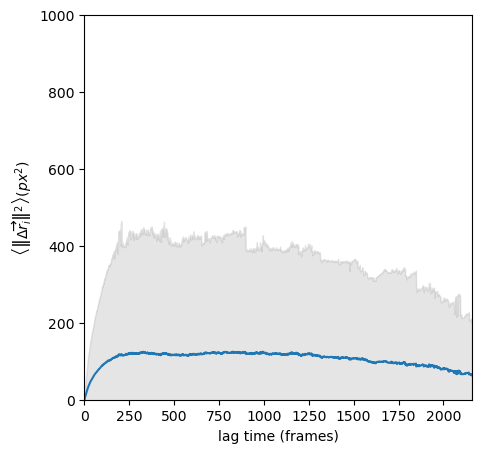

In [21]:
msd_df_ = msd_df
msd_df_["squared displacement from origin"] = msd_df_["displacement from origin"].apply(lambda x: x*x)
msd = msd_df_.groupby("dt acc")["squared displacement from origin"].mean()
msd_sd = msd_df_.groupby("dt acc")["squared displacement from origin"].std()
#single_tcell_df = msd_df_.loc[msd_df_["track_id"]==TRACK_ID_TCELL]

print(msd, msd_sd)
# track_id = 100

fig, axs = plt.subplots(1,1,figsize=(5,5))
msd.plot(
    ax=axs,
    xlabel="lag time (frames)",
    ylabel=r'$\left\langle \left\| \Delta \overrightarrow{r}_i \right\|^2 \right\rangle (px^2)$'
    )
axs.fill_between(np.arange(len(msd_sd)),msd-msd_sd,msd+msd_sd, color='gray', alpha=0.2, label='Std Dev')
axs.set_xlim([0,2159])
axs.set_ylim([0,1000])

#axs.set_yscale("log")
#axs.set_xscale("log")

### Calculate MSD for consecutive points in space 

In [21]:
msd_df_data = tracks_df_filtered_tcell[["label","x","y","track_id", "frame", "dx from previous point", "dy from previous point", "displacement from previous point"]]

msd_df_data = msd_df_data.sort_values(by=["track_id","frame"])
msd_results = pd.DataFrame(columns=["track_id", "dt", "msd"])

for t_id in tqdm(range(100,200)):
    #print(t_id)
    curr_track = msd_df_data.loc[msd_df_data["track_id"]==t_id]
    dt_array=[]
    if int(len(curr_track["frame"]))>0:
        #for dt in tqdm(np.logspace(0,100/int(len(curr_track["frame"])*0.7),num=30, base=10)):
        for dt in tqdm(range(1,int(len(curr_track["frame"])*0.7))):
            sd=[]
            dt=int(dt)
            #dt_array.append(dt)
            for t in range(len(curr_track["frame"])-int(dt)):
                #print(t, dt)
                try:
                    dx=(curr_track.loc[curr_track["frame"]==(t+dt),'x'].values[0]- curr_track.loc[curr_track["frame"]==t,'x'].values[0])**2
                    dy =(curr_track.loc[curr_track["frame"]==(t+dt),'y'].values[0]- curr_track.loc[curr_track["frame"]==t,'y'].values[0])**2
                    sd.append(dx + dy)
                    #
                except IndexError:
                    break

            msd_results.loc[len(msd_results)] = [t_id, dt, np.nanmean(sd)]
            #msd_results = pd.concat[t_id, dt, np.nanmean(sd)]
            # msd_results["msd"] = np.nanmean(sd)image.size[0]
            # msd_results["dt"] = dt
            # msd_results["track_id"] = t_id
    #msd_df_data["dt"] = dt_array


  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_2093719/1050574670.py:26: RuntimeWarning: Mean of empty slice
  msd_results.loc[len(msd_results)] = [t_id, dt, np.nanmean(sd)]
/tmp/ipykernel_2093719/1050574670.py:26: RuntimeWarning: Mean of empty slice
  msd_results.loc[len(msd_results)] = [t_id, dt, np.nanmean(sd)]
/tmp/ipykernel_2093719/1050574670.py:26: RuntimeWarning: Mean of empty slice
  msd_results.loc[len(msd_results)] = [t_id, dt, np.nanmean(sd)]
/tmp/ipykernel_2093719/1050574670.py:26: RuntimeWarning: Mean of empty slice
  msd_results.loc[len(msd_results)] = [t_id, dt, np.nanmean(sd)]
/tmp/ipykernel_2093719/1050574670.py:26: RuntimeWarning: Mean of empty slice
  msd_results.loc[len(msd_results)] = [t_id, dt, np.nanmean(sd)]
/tmp/ipykernel_2093719/1050574670.py:26: RuntimeWarning: Mean of empty slice
  msd_results.loc[len(msd_results)] = [t_id, dt, np.nanmean(sd)]
/tmp/ipykernel_2093719/1050574670.py:26: RuntimeWarning: Mean of empty slice
  msd_results.loc[len(msd_result

In [22]:
fig, axs = plt.subplots(1,2,figsize=(10,5),sharey=True,gridspec_kw={'width_ratios': [3, 1]})

msd_hist_values=[]

threshold=20

for track_id in tqdm(msd_results["track_id"].unique()):
    single_cell_df = msd_results.loc[msd_results["track_id"]==track_id]
    single_cell_df = single_cell_df.sort_values(by=["dt"])
    axs[0].scatter(single_cell_df['dt'], single_cell_df['msd'], label=track_id,s=3)image.size[0]
    axs[0].plot(single_cell_df['dt'], single_cell_df['msd'], label=track_id)
    axs[0].set_yscale("log")
    axs[0].set_xscale("log")
    if len(single_cell_df)>threshold:
        i=single_cell_df.loc[single_cell_df["dt"]==threshold,"msd"].values[0]
        msd_hist_values.append(i)
print(len(msd_hist_values))

msd_hist_values=[i for i in msd_hist_values if str(i) != 'nan']

axs[0].set_ylim(1e-2,1.5e2)
axs[0].vlines(threshold,1e-2,1.5e2,color='k')
H,B=np.histogram(msd_hist_values)
H_norm=H/len(msd_hist_values)image.size[0]
axs[1].barh(B[:-1],H,height=1,align='edge')
#axs[1].set_xlim(0,1)

axs[0].set_xlabel(r'$\tau$ / frames')
axs[0].set_ylabel(r'$\left\langle \left\| \Delta \overrightarrow{r}_i \right\|^2 \right\rangle (px^2)$ / px$^2$')
axs[1].set_xlabel(r'fraction')


SyntaxError: invalid syntax (1844995752.py, line 10)

### Displacement vs Travelled Distances

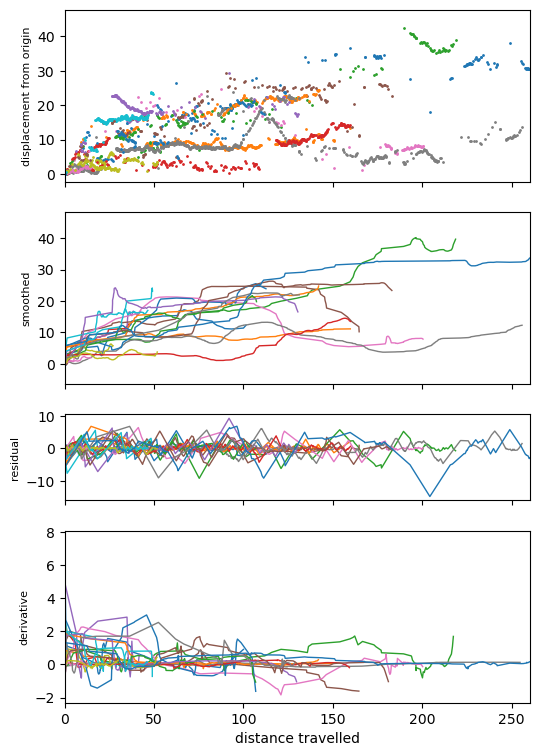

In [23]:
from tqdm import tqdm
from  scipy.signal import savgol_filter 

fig, axs = plt.subplots(4,1,figsize=(6,9),sharex=True,height_ratios=[2, 2,1,2])
#axs.set_xlim(0,100)
#axs.set_ylim(0,100)

# isolate one cell
TRACK_ID_TCELL = 37

for t_id in range(400,450):

    single_tcell_df = tracks_df_filtered_tcell.loc[tracks_df_filtered_tcell["track_id"]==t_id]
    single_tcell_df = single_tcell_df.sort_values(by=["frame"])
    data = single_tcell_df["displacement from origin"]
    if len(data) < 18:
        continue
    smooth = savgol_filter(data,mode="interp", window_length=int(len(data)/2)-1, polyorder=6)
    #smooth = savgol_filter(data,mode="interp", window_length=len(data)-1, polyorder=5)
    diff_tcell = np.diff(smooth)
    #diff_tcell.extend(diff_tcell[-1])


    axs[0].scatter(single_tcell_df["distance travelled"], single_tcell_df["displacement from origin"], s=1)
    #axs[0].set_xlabel("distance travelled")
    axs[0].set_ylabel("displacement from origin",fontsize=8)
    axs[0].set_xlim(0,260)

    axs[1].plot(single_tcell_df["distance travelled"], smooth, lw=1)
    #axs[1].set_xlabel("distance travelled")
    axs[1].set_ylabel("smoothed",fontsize=8)
    axs[1].set_xlim(0,260)

    axs[2].plot(single_tcell_df["distance travelled"], data-smooth, lw=1)
    #axs[1].set_xlabel("distance travelled")
    axs[2].set_ylabel("residual",fontsize=8)
    axs[2].set_xlim(0,260)

    axs[3].plot(single_tcell_df["distance travelled"][:-1], diff_tcell, lw=1)
    axs[3].set_xlabel("distance travelled")
    axs[3].set_ylabel("derivative",fontsize=8)
    axs[3].set_xlim(0,260)
    #axs[1].set_ylabel("displacement from origin")


# for t in tqdm(range(2000)):
#     single_tcell_df_ = single_tcell_df[single_tcell_df["frame"] == t]
#     single_tcell_df_.plot("distance travelled","displacement from origin",ax=axs,lw=0.2)

# axs.get_legend().remove()

### Speed 

In [4]:
tracks_df_filtered_tcell_ = tracks_df_filtered_tcell

tracks_df_filtered_tcell_

speed = tracks_df_filtered_tcell_.groupby(["track_id"])["speed"].mean()
pd.set_option("display.max_columns", None)
speed

track_id
1         0.626071
2         0.649740
6         1.305056
7         0.565777
9         0.790364
            ...   
169579    0.202918
169580    0.221480
169581    0.210520
169582    0.207455
169584    0.653115
Name: speed, Length: 91729, dtype: float64

In [5]:
#tracks_df_filtered_tcell_speed = tracks_df_filtered_tcell_.groupby(["track_id"])
tracks_df_filtered_tcell_speed = tracks_df_filtered_tcell_.sort_values(by=["track_id"])
pd.set_option("display.max_rows", 100)
#tracks_df_filtered_tcell_speed.tail(50)

/tmp/ipykernel_1807455/2555422446.py:22: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axes[0].set_xlim([0,10])
/tmp/ipykernel_1807455/2555422446.py:61: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axes[1].set_xlim([0,10])


0.02794165235262203 0.15572486015126993


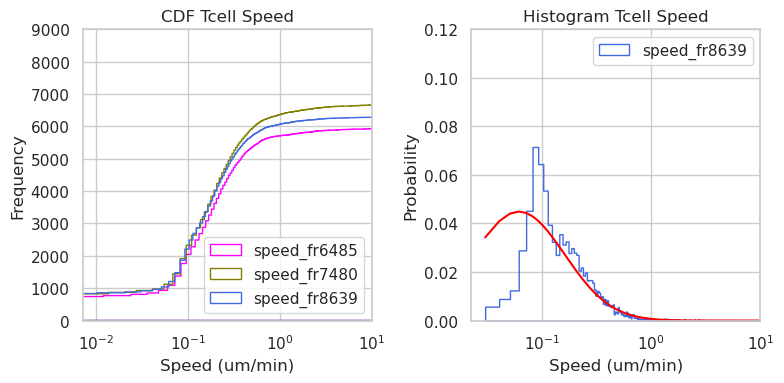

In [49]:
import seaborn as sns
from scipy import stats

tracks_df_filtered_tcell_speed_5 = tracks_df_filtered_tcell[tracks_df_filtered_tcell["frame"]==5]
tracks_df_filtered_tcell_speed_1000 = tracks_df_filtered_tcell[tracks_df_filtered_tcell["frame"]==1000]
tracks_df_filtered_tcell_speed_1500 = tracks_df_filtered_tcell[tracks_df_filtered_tcell["frame"]==2158]

# Plot tcell histogram
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
sns.set(style='whitegrid')
sns.histplot(data=tracks_df_filtered_tcell_speed_5, x='speed', bins=1000, kde=False, edgecolor='magenta', label='speed_fr6485', stat="frequency", element="step",common_norm=False, cumulative=True,alpha=0,ax=axes[0])
sns.histplot(data=tracks_df_filtered_tcell_speed_1000, x='speed', bins=1000, kde=False, edgecolor='olive', label='speed_fr7480',stat="frequency",element="step",common_norm=False,cumulative=True,alpha=0,ax=axes[0])
sns.histplot(data=tracks_df_filtered_tcell_speed_1500, x='speed', bins=1000, kde=False, edgecolor='royalblue', label='speed_fr8639', stat="frequency", element="step",common_norm=False,cumulative=True, alpha=0,ax=axes[0])
axes[0].set_title('CDF Tcell Speed')
axes[0].set_xlabel("Speed (um/min)")
tickpos=[1e-2,1e-1,1e0,1e1]
ticklabel = [t*1.6*10.0/60. for t in tickpos]

axes[0].set_xticks(tickpos,ticklabel)
axes[0].set_ylabel("Frequency")
axes[0].set_xscale("log")
axes[0].set_xlim([0,10])
axes[0].set_ylim([0,9000])
axes[0].legend(loc=4)
plt.tight_layout()

# sns.histplot(data=tracks_df_filtered_tcell_speed_5, x='speed', bins=1000, kde=False, edgecolor='magenta', label='speed_fr5', stat="probability", element="step",common_norm=False, cumulative=False,alpha=0,ax=axes[1])
# sns.histplot(data=tracks_df_filtered_tcell_speed_1000, x='speed', bins=1000, kde=False, edgecolor='olive', label='speed_fr1000',stat="probability",element="step",common_norm=False,cumulative=False,alpha=0,ax=axes[1])
# sns.histplot(data=tracks_df_filtered_tcell_speed_1500, x='speed', bins=1000, kde=False, edgecolor='royalblue', label='speed_fr1900', stat="probability", element="step",common_norm=False,cumulative=False, alpha=0,ax=axes[1])
axes[1].set_title('Histogram Tcell Speed')
axes[1].set_xlabel("Speed (um/min)")
axes[1].set_ylim([0,0.12])

fit_y=tracks_df_filtered_tcell_speed_1500['speed']
fit_y= fit_y[fit_y>3e-2]
sns.histplot(data=fit_y, bins=1000, kde=False, edgecolor='royalblue', label='speed_fr8639', stat="probability", element="step",common_norm=False, cumulative=False,alpha=0,ax=axes[1])
H,B=np.histogram(fit_y, bins=1000)
# H_norm=H/np.sum(H)
# mean, var, skew, kurt = stats.lognorm.stats(fit_y,moments="mvsk")
# print(
#     "mean: ",mean,
#     "var: ", var,
#     "skew: ", skew,
#     "kurt: ",kurt
# )
sigma,loc,exp_mu=stats.lognorm.fit(fit_y,method='MLE')
mu = np.log(exp_mu)
# x = np.linspace(1e-2,1e1,2000)
x = B
print(loc,exp_mu)
pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))/ (x * sigma * np.sqrt(2 * np.pi)))
pdf = pdf/np.sum(pdf)
axes[1].plot(x,pdf,color="red")

# tickpos=[1e-2,1e-1,1e0,1e1]
# ticklabel = [t*1.6*10.0/60. for t in tickpos]

# axes[1].set_xticks(tickpos,ticklabel)
axes[1].set_ylabel("Probability")
axes[1].set_xscale("log")
axes[1].set_xlim([0,10])
axes[1].legend(loc=1)
plt.tight_layout()

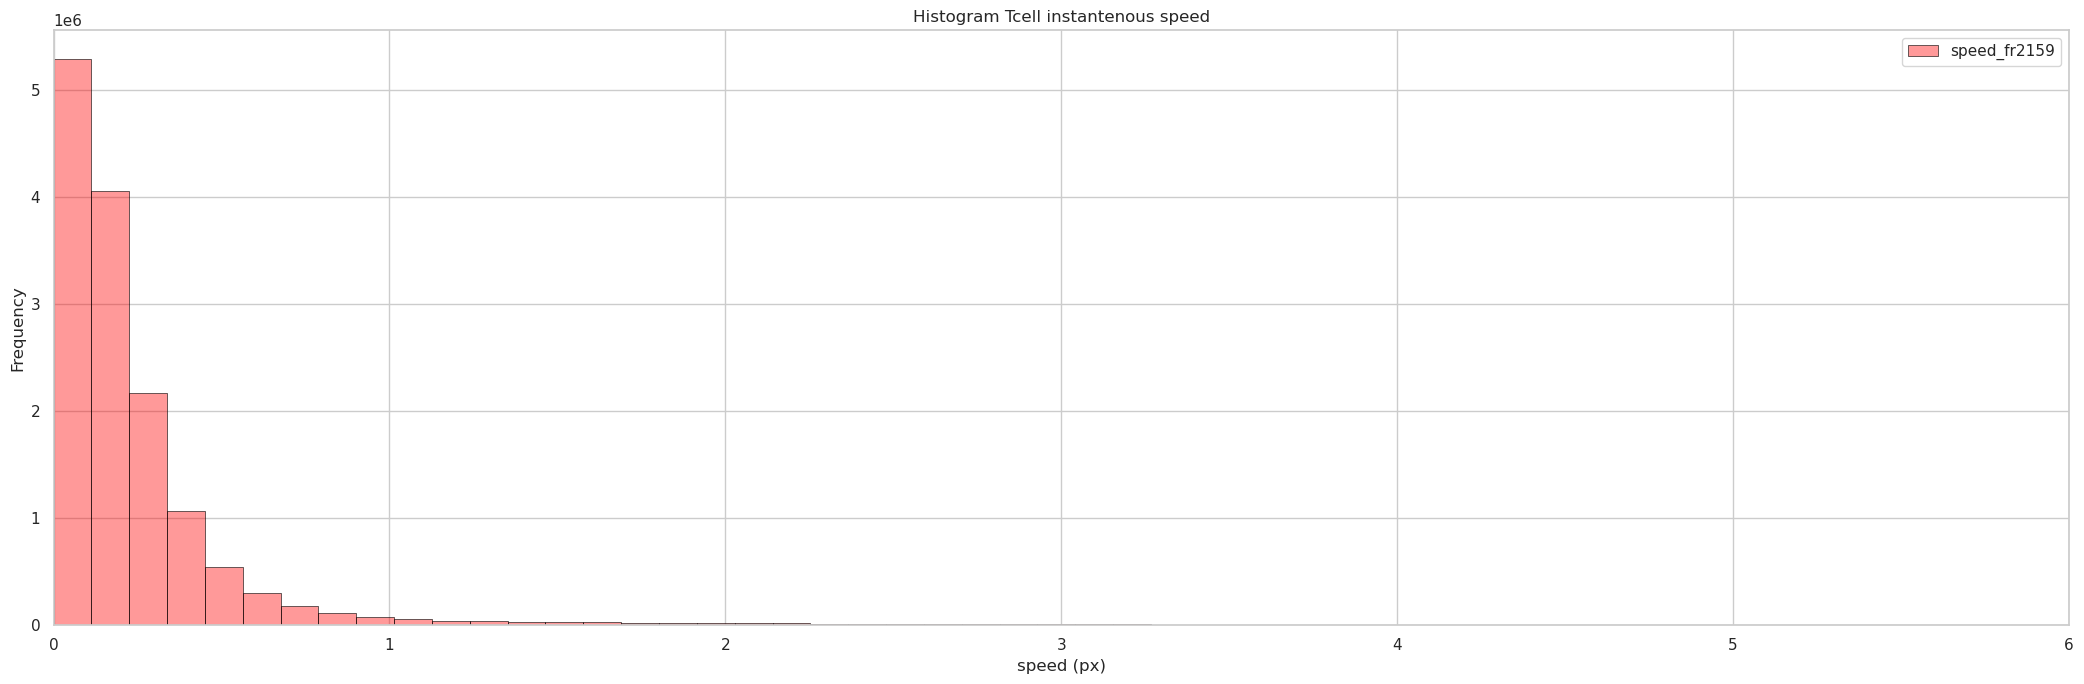

In [50]:
import seaborn as sns

tracks_df_filtered_tcell_speed = tracks_df_filtered_tcell_.sort_values(by=["track_id"])


# Plot tcell histogram
fig, axes = plt.subplots(1, 1, figsize=(21, 7))
sns.set(style='whitegrid')
#axes = axes.flatten()
sns.histplot(data=tracks_df_filtered_tcell_speed, x='speed', bins=256, kde=False, color='red', edgecolor='black', label='speed_fr2159', alpha=0.4)
#sns.histplot(data=tracks_df_filtered_tcell_speed_1000, x='speed', bins=100, kde=False, color='blue', edgecolor='black', label='speed_fr1000',alpha=0.4)
#sns.histplot(data=tracks_df_filtered_tcell_speed_1500, x='speed', bins=100, kde=False, color='green', edgecolor='black', label='speed_fr1900',alpha=0.4)
axes.set_title('Histogram Tcell instantenous speed')
axes.set_xlabel("speed (px)")
axes.set_ylabel("Frequency")
#axes[0].set_yscale("log")
axes.set_xlim([0,6])
axes.legend()
plt.tight_layout()

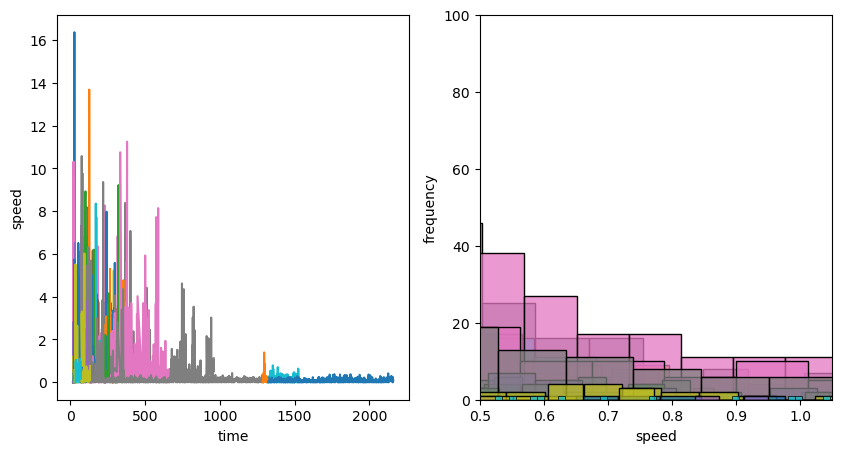

In [6]:
from tqdm import tqdm
import seaborn as sns

fig, axs = plt.subplots(1,2,figsize=(10,5))
#axs.set_xlim(0,100)
#axs.set_ylim(0,100)


#tracks_df_filtered_tcell["dy from origin"] = tracks_df_filtered_tcell.groupby(['track_id'])['dy from previous point'].cumsum().fillna(0)

# isolate one cell
TRACK_ID_TCELL = 37

for t_id in range(400,500):

    single_tcell_df = tracks_df_filtered_tcell_.loc[tracks_df_filtered_tcell_["track_id"]==t_id]
    single_tcell_df = single_tcell_df.sort_values(by=["frame"])

    axs[0].plot(single_tcell_df["frame"], single_tcell_df["speed"])
    axs[0].set_xlabel("time")
    axs[0].set_ylabel("speed")

    sns.histplot(data=single_tcell_df, x='speed', bins=100, ax=axs[1])
    axs[1].set_xlabel("speed")
    axs[1].set_ylabel("frequency")
    axs[1].set_xlim((0.5))
    axs[1].set_ylim((0,100))

In [40]:
single_tcell_df = tracks_df_filtered_tcell_.loc[tracks_df_filtered_tcell_["track_id"]==500]
single_tcell_df = single_tcell_df.sort_values(by=["frame"])
single_tcell_df["average speed"] = single_tcell_df["speed"].mean()
single_tcell_df[["tracked frames","tracked length","dt acc", "speed", "average speed"]]

,tracked frames,tracked length,dt acc,speed,average speed


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


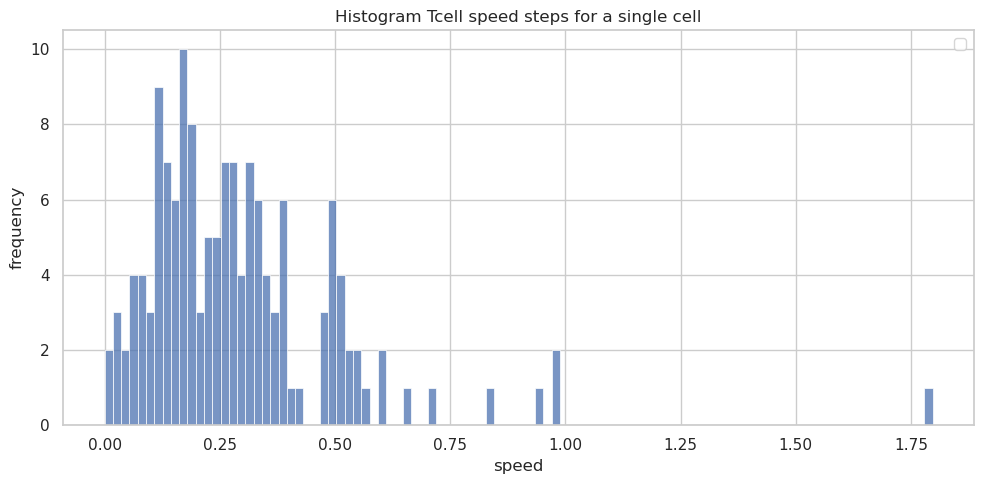

In [42]:
import seaborn as sns

single_tcell_df = tracks_df_filtered_tcell_.loc[tracks_df_filtered_tcell_["track_id"]==300]
single_tcell_df = single_tcell_df.sort_values(by=["frame"])

# Plot tcell histogram
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
#axes = axes.flatten()
sns.histplot(data=single_tcell_df, x='speed', bins=100)
axes.set_title('Histogram Tcell speed steps for a single cell')
axes.set_xlabel("speed")
axes.set_ylabel("frequency")
#axes[0].set_yscale("log")
axes.legend()
plt.tight_layout()


### Displacement and distance travelled ensemble histograms for T cells and Cancer Cells

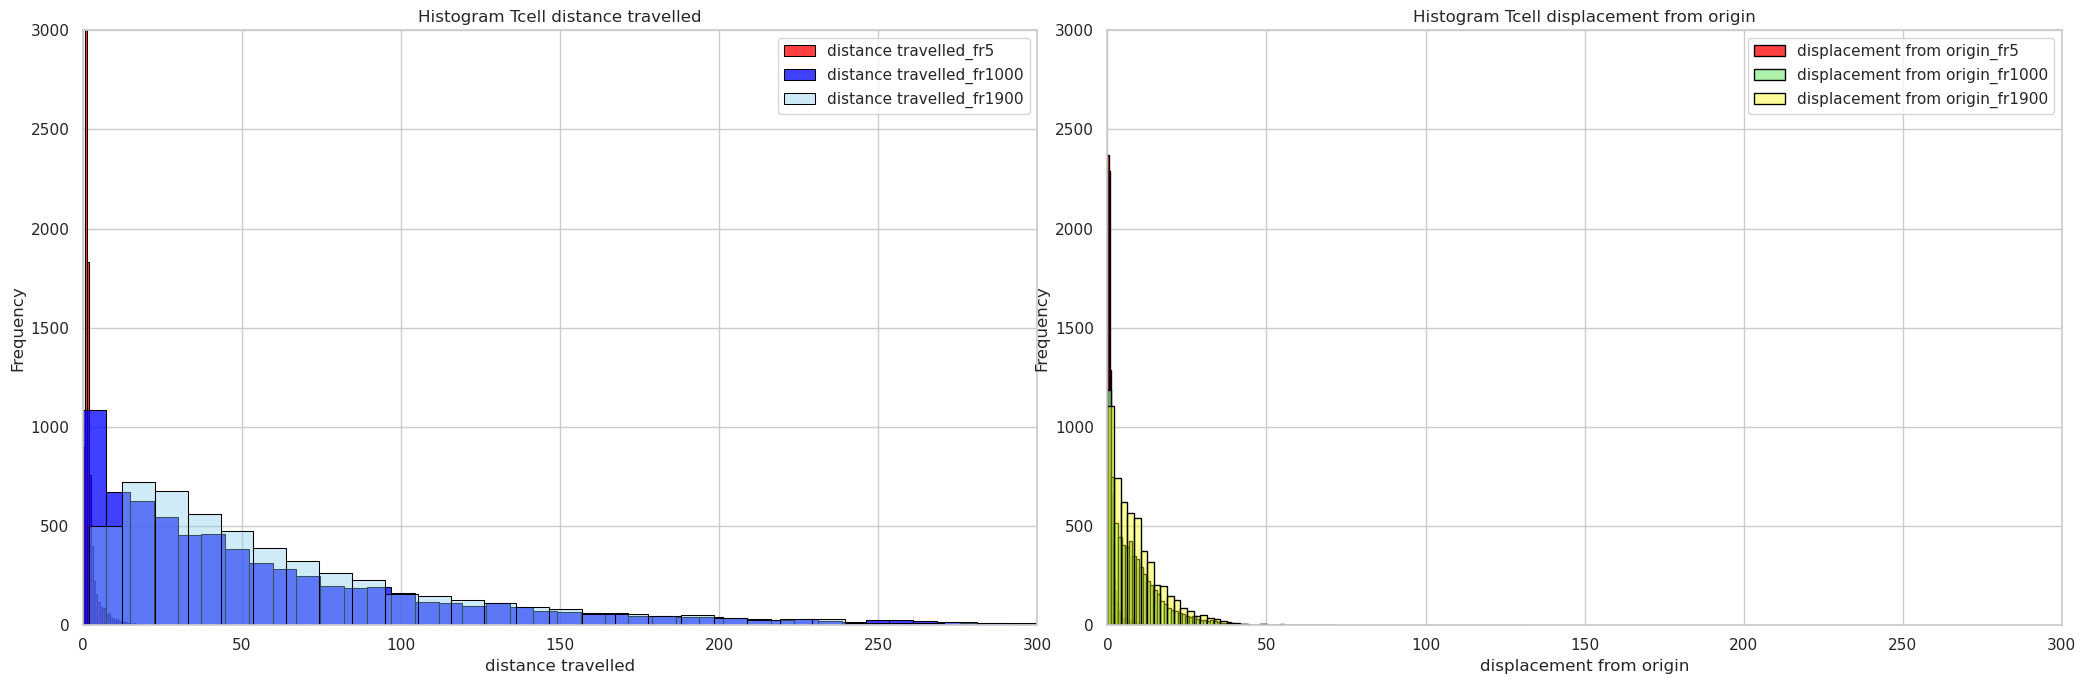

In [46]:
import seaborn as sns

#axs.set_xlim(0,3)
#axs.set_ylim(0,125)
# Set Seaborn style
sns.set(style='whitegrid')
_speed = tracks_df_filtered_tcell_.sort_values(by=["track_id"])_tcell[tracks_df_filtered_tcell["frame"]==2159]

tracks_df_filtered_tcell_corr_5 = tracks_df_filtered_tcell[tracks_df_filtered_tcell["frame"]==5]
tracks_df_filtered_tcell_corr_1000 = tracks_df_filtered_tcell[tracks_df_filtered_tcell["frame"]==1000]
tracks_df_filtered_tcell_corr_1500 = tracks_df_filtered_tcell[tracks_df_filtered_tcell["frame"]==2159]


# tracks_df_filtered_cancer_bright_5 = tracks_df_filtered_cancer[tracks_df_filtered_cancer["frame"]==5]
# tracks_df_filtered_cancer_bright_1000 = tracks_df_filtered_cancer[tracks_df_filtered_cancer["frame"]==1000]
# tracks_df_filtered_cancer_bright_1500 = tracks_df_filtered_cancer[tracks_df_filtered_cancer["frame"]==1900]

# tracks_df_filtered_cancer_corr_5 = tracks_df_filtered_cancer[tracks_df_filtered_cancer["frame"]==5]
# tracks_df_filtered_cancer_corr_1000 = tracks_df_filtered_cancer[tracks_df_filtered_cancer["frame"]==1000]
# tracks_df_filtered_cancer_corr_1500 = tracks_df_filtered_cancer[tracks_df_filtered_cancer["frame"]==1900]



# Plot tcell histogram
fig, axes = plt.subplots(1, 2, figsize=(21, 7))
axes = axes.flatten()
sns.histplot(data=tracks_df_filtered_tcell_bright_5, x='distance travelled', bins=64, kde=False, color='red', edgecolor='black',ax=axes[0], label='distance travelled_fr5')
sns.histplot(data=tracks_df_filtered_tcell_bright_1000, x='distance travelled', bins=64, kde=False, color='blue', edgecolor='black',ax=axes[0], label='distance travelled_fr1000')
sns.histplot(data=tracks_df_filtered_tcell_bright_1500, x='distance travelled', bins=64, kde=False, color='skyblue', edgecolor='black', label='distance travelled_fr1900',ax=axes[0],alpha=0.4)
axes[0].set_title('Histogram Tcell distance travelled')
axes[0].set_xlabel("distance travelled")
axes[0].set_ylabel("Frequency")
axes[0].set_xlim([0,300])
axes[0].set_ylim([0,3000])
#axes[0].set_yscale("log")
axes[0].legend()
plt.tight_layout()

# Plot a histogram
sns.histplot(data=tracks_df_filtered_tcell_bright_5, x='displacement from origin', bins=64, kde=False, color='red', edgecolor='black', ax=axes[1],label='displacement from origin_fr5')
sns.histplot(data=tracks_df_filtered_tcell_bright_1000, x='displacement from origin', bins=64, kde=False, color='lightgreen', edgecolor='black', ax=axes[1],label='displacement from origin_fr1000')
sns.histplot(data=tracks_df_filtered_tcell_bright_1500, x='displacement from origin', bins=64, kde=False, color="yellow", edgecolor='black', ax=axes[1], label='displacement from origin_fr1900', alpha=0.4)
axes[1].set_title('Histogram Tcell displacement from origin')
axes[1].set_xlabel("displacement from origin")
axes[1].set_ylabel("Frequency")
axes[1].set_xlim([0,300])
axes[1].set_ylim([0,3000])
#axes[1].set_yscale("log")
axes[1].legend()

# # Plot a histogram
# sns.histplot(data=tracks_df_filtered_tcell_corr_5, x='corr_mean', bins=64, kde=False, color='red', edgecolor='black', ax=axes[2],label='corr_mean_fr5')
# sns.histplot(data=tracks_df_filtered_tcell_corr_1000, x='corr_mean', bins=64, kde=False
# #### Plot cancer histogram
# fig, axes = plt.subplots(1, 2, figsize=(21, 7))
# axes = axes.flatten()
# sns.histplot(data=tracks_df_filtered_cancer_bright_5, x='distance travelled', bins=64, kde=False, color='blue', edgecolor='black', label='distance travelled_fr5', ax=axes[0])
# sns.histplot(data=tracks_df_filtered_cancer_bright_1000, x='distance travelled', bins=64, kde=False, color='green', edgecolor='black', label='distance travelled_fr1000',alpha=0.4, ax=axes[0])
# sns.histplot(data=tracks_df_filtered_cancer_bright_1500, x='distance travelled', bins=64, kde=False, color='skyblue', edgecolor='black', label='distance travelled_fr1900', alpha=0.4,ax=axes[0])
# axes[0].set_title('Histogram cancer distance travelled')
# axes[0].set_xlabel("distance travelled")
# axes[0].set_ylabel("Frequency")
# #axes[0].set_yscale("log")
# axes[0].legend()
# plt.tight_layout()

# # Plot a histogram
# sns.histplot(data=tracks_df_filtered_cancer_bright_5, x='displacement from origin', bins=64, kde=False, color='red', edgecolor='black', label='displacement from origin_fr5', ax=axes[1])
# sns.histplot(data=tracks_df_filtered_cancer_bright_1000, x='displacement from origin', bins=64, kde=False, color='lightgreen', edgecolor='black', label='displacement from origin_fr1000',alpha=0.4, ax=axes[1])
# sns.histplot(data=tracks_df_filtered_cancer_bright_1500, x='displacement from origin', bins=64, kde=False, color='yellow', edgecolor='black', label='displacement from origin_fr1900', alpha=0.4,ax=axes[1])
# axes[1].set_title('Histogram displacement from origin')
# axes[1].set_xlabel("displacement from origin")
# axes[1].set_ylabel("Frequency")
# #axes[1].set_yscale("log")
# axes[1].legend(), color='lightgreen', edgecolor='black', ax=axes[2],label='corr_mean_fr1000')
# sns.histplot(data=tracks_df_filtered_tcell_corr_1500, x='corr_mean', bins=64, kde=False, color="yellow", edgecolor='black', ax=axes[2], label='corr_mean_fr1900', alpha=0.4)
# axes[2].set_title('Histogram Tcell corr')
# axes[2].set_xlabel("Mean Corr brightness")
# axes[2].set_ylabel("Frequency")
# axes[2].set_yscale("log")
# axes[2].set_xlim([32000,44000])
# axes[2].legend()

# plt.tight_layout()


# #### Plot cancer histogram
# fig, axes = plt.subplots(1, 2, figsize=(21, 7))
# axes = axes.flatten()
# sns.histplot(data=tracks_df_filtered_cancer_bright_5, x='distance travelled', bins=64, kde=False, color='blue', edgecolor='black', label='distance travelled_fr5', ax=axes[0])
# sns.histplot(data=tracks_df_filtered_cancer_bright_1000, x='distance travelled', bins=64, kde=False, color='green', edgecolor='black', label='distance travelled_fr1000',alpha=0.4, ax=axes[0])
# sns.histplot(data=tracks_df_filtered_cancer_bright_1500, x='distance travelled', bins=64, kde=False, color='skyblue', edgecolor='black', label='distance travelled_fr1900', alpha=0.4,ax=axes[0])
# axes[0].set_title('Histogram cancer distance travelled')
# axes[0].set_xlabel("distance travelled")
# axes[0].set_ylabel("Frequency")
# #axes[0].set_yscale("log")
# axes[0].legend()
# plt.tight_layout()

# # Plot a histogram
# sns.histplot(data=tracks_df_filtered_cancer_bright_5, x='displacement from origin', bins=64, kde=False, color='red', edgecolor='black', label='displacement from origin_fr5', ax=axes[1])
# sns.histplot(data=tracks_df_filtered_cancer_bright_1000, x='displacement from origin', bins=64, kde=False, color='lightgreen', edgecolor='black', label='displacement from origin_fr1000',alpha=0.4, ax=axes[1])
# sns.histplot(data=tracks_df_filtered_cancer_bright_1500, x='displacement from origin', bins=64, kde=False, color='yellow', edgecolor='black', label='displacement from origin_fr1900', alpha=0.4,ax=axes[1])
# axes[1].set_title('Histogram displacement from origin')
# axes[1].set_xlabel("displacement from origin")
# axes[1].set_ylabel("Frequency")
# #axes[1].set_yscale("log")
# axes[1].legend()

# # Plot a histogram
# sns.histplot(data=tracks_df_filtered_cancer_corr_5, x='corr_mean', bins=64, kde=False, color='red', edgecolor='black', ax=axes[2],label='corr_mean_fr5')
# sns.histplot(data=tracks_df_filtered_cancer_corr_1000, x='corr_mean', bins=64, kde=False, color='lightgreen', edgecolor='black', ax=axes[2],label='corr_mean_fr1000')
# sns.histplot(data=tracks_df_filtered_cancer_corr_1500, x='corr_mean', bins=64, kde=False, color="yellow", edgecolor='black', ax=axes[2], label='corr_mean_fr1900', alpha=0.4)
# axes[2].set_title('Histogram Tcell corr')
# axes[2].set_xlabel("Mean Corr brightness")
# axes[2].set_ylabel("Frequency")
# axes[2].set_yscale("log")
# axes[2].set_xlim([32000,44000])
# axes[2].legend()



# plt.tight_layout()


Plot tracks in space centered at their initial position 

In [ ]:
def plot_tracks(tracks_df: pd.DataFrame) -> None:
    """Center tracks at their initial position and plot them.

    Parameters
    ----------
    tracks_df : pd.DataFrame
        Tracks datafarame sorted by `track_id` and `t`.

    Returns
    -------
    pd.DataFrame
        Centered dataframe.
    """
    centered_df = tracks_df.copy()
    centered_df[["y", "x"]] = centered_df.groupby(
        "track_id",
        as_index=False,
    )[["y", "x"]].transform(lambda x: x - x.iloc[0])

    # sanity check
    assert (centered_df[centered_df["frame"] == 0][["y", "x"]] == 0).all().all()

    pallete = sns.color_palette(["gray"], len(centered_df["track_id"].unique()))
    sns.lineplot(
        data=centered_df,
        x="x",
        y="y",
        hue="track_id",
        palette=pallete,
        legend=False,
        alpha=0.5,
        sort=False,
        estimator=None,
    )

    return centered_df

In [ ]:
import seaborn as sns
plot_tracks(msd_df)

Plot tracks in space

In [ ]:
track_id = 10

fig, axs = plt.subplots(1,1,figsize=(10,5))

for t_id in tqdm(range(2000)):
    single_cell_df = msd_df.loc[msd_df["track_id"]==t_id]
    single_cell_df = single_cell_df.sort_values(by=["frame"])
    axs.plot(single_cell_df['x'], single_cell_df['y'], label=track_id)